In [612]:
%%javascript
// Remove annoyances from notebook.
// get rid of the double-scrollbar annoyance
var xs = $('div.nbp-app-bar');
if (xs.length > 0) { xs[0].style.display = 'none'; }
// disable the annoying up/down arrow shortcuts that move cells instead of moving the page.
try { Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
      Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down'); } catch (Exception) {};

<IPython.core.display.Javascript object>

In [613]:
import re, pickle, numpy as np, pandas as pd, dateutil, sys
from path import Path
import seaborn as sns
from pprint import pprint
from dyna.dyna1 import Program
from path import Path
from argparse import ArgumentParser
from arsenal import colors, iterview

from experiments.benchmarks import benchmark
from experiments.configurations import search_alg, search_graph
from experiments.util import load_program, load, dump

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 2)

In [614]:
!cd /home/timv/projects/dyna-pi/

In [615]:
!./pull-results.bash >& /dev/null && echo done

done


In [628]:
def load_result(x):
    s = x / 'start'
    y = dict(
        directory = x,
        started = False,
        finished = False,
    )
    if not s.exists(): return y   
    s = dateutil.parser.parse(s.text())
    f = x / 'finish'
    f = dateutil.parser.parse(f.text()) if f.exists() else None
    y.update(dict(
        start = s, 
        started = True,
        finish = f, 
        jobid = (x / 'jobid.txt').text().strip(), 
        finished = (f is not None),
    ))
    try: args = load(x / 'args.pkl')
    except:
        print(colors.red % 'error bad args.pkl', x)
        return y
    
    if args.beam_size is None: args.beam_size = 0
    y.update(args.__dict__)

    try: sol = load(x / 'solution.pkl')
    except EOFError: sol = None
    if sol is None: 
        print('missing solution', x)
        return y

    init = load(args.filename)
    # XXX: dropping jobs that are not in the current set of benchmarks
    if args.benchmark not in benchmark: return None
    b = benchmark[args.benchmark]
    y.update(dict(
        optimal_degree = b.optimal,
        start_program = init,
        start_degree = init.degree,
        best_program = sol,
        best_degree = sol.degree,
        optimal = (sol.degree <= b.optimal),
    ))
    return y

In [629]:
Path('/home/timv/projects/dyna-pi/').chdir()

#r = Path('results-5b')
r = Path('results-3b')
#r = Path('results-3')
#r = Path('results')
assert r.exists()

data = []
for x in iterview(r.glob('*')):
    y = load_result(x)
    if y is None: continue
    data.append(y)

df = pd.DataFrame(data)

100.0% (4050/4050) [==================================================] 00:00:13


### Job progress

What is still running?

In [630]:
# Workaround because I couldn't quickly figure out how tzinfo works in datetime.now() packages
[now] = !date
now = dateutil.parser.parse(now.strip())
unfinished = df[~df.finished].copy()
#unfinished = unfinished[unfinished.benchmark != 'cky5']

unfinished['elapsed'] = now - unfinished.start
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(unfinished[['directory','filename','jobid','elapsed']].sort_values('elapsed'))

print('number of unfinished jobs:', len(unfinished))

unfinished[['directory','filename','jobid','elapsed']].sort_values('elapsed')

number of unfinished jobs: 2710


,directory,filename,jobid,elapsed
2022,results-3b/2021-09-12-jj3-8073da6f26215a369c6c...,stress-tests/3/cky4/05.pkl,2888497,0 days 21:58:38
1798,results-3b/2021-09-12-jj3-2e284e11d4d6c1e26e59...,stress-tests/3/itg/00.pkl,2888387,0 days 22:07:55
2347,results-3b/2021-09-12-jj3-95dc74babcf792e1084b...,stress-tests/3/cky3/00.pkl,2888385,0 days 22:08:04
2582,results-3b/2021-09-12-jj3-e9df05270d21c0bec6d9...,stress-tests/3/cky3/07.pkl,2888251,0 days 22:19:30
2535,results-3b/2021-09-12-jj3-62b07be6b3a4e40492ac...,stress-tests/3/edit/05.pkl,2888175,0 days 22:25:51
...,...,...,...,...
4045,results-3b/2021-09-12-jj3-bd87dd9ea73109d56692...,NaN,NaN,NaT
4046,results-3b/2021-09-12-jj3-3202275f16ba11365e68...,NaN,NaN,NaT
4047,results-3b/2021-09-12-jj3-91afc5d9d0c8f1f49cf0...,NaN,NaN,NaT
4048,results-3b/2021-09-12-jj3-e7799039e72ec94fba8d...,NaN,NaN,NaT


In [631]:
#%%bash
#cat results-3b/2021-09-12-jj3-edab818c0b8093930d39*/cmd.txt
#echo
#ls results-3b/2021-09-12-jj3-edab818c0b8093930d39*/

In [632]:
#from collections import defaultdict
#fs = defaultdict(lambda: defaultdict(list))
#for x in df.itertuples():
#    if not x.started:
#        print(x.directory)
#        fs[x.filename][x.started].append(x)

What might not have started?

In [633]:
sss = df.groupby(['benchmark', 'search', 'graph', 'beam_size']).started.sum()
# list algorithms configs where not all 10 instances have started - empty is good.
print(sss[sss != 10])

Series([], Name: started, dtype: int64)


In [634]:
fff = df.groupby(['benchmark', 'search', 'graph', 'beam_size']).finished.sum()
# list algorithms configs where not all 10 instances have finished - empty is good.
print(fff[fff != 10])

benchmark            search  graph   beam_size
bilexical-unlabeled  mcts    basic2  0.0          9
cky0                 mcts    basic2  0.0          9
cky3                 mcts    basic2  0.0          8
cky4                 mcts    basic2  0.0          9
                             macro2  0.0          9
edit                 mcts    macro2  0.0          9
itg                  mcts    basic2  0.0          7
Name: finished, dtype: int64


## Performance

Overall by method configurations

Relative degree is not great metric, but I like that it gives partial credit for jobs that improved the running time a lot, but fell just short of optimal (e.g., from $n^{13}$ to $n^4$ is a big improvement even tho optimal is $n^3$).

$$
1 - \frac{x - x*}{x_0 - x^*}
$$

However, since differences in degree are essentially on a $\log_\eta$-scale, we should probably map them back in order to compare.

$$
1 - \frac{\eta^{x} - \eta^{x*}}{\eta^{x_0} - \eta^{x*}}
$$

In [635]:
def rel_degree(x):
    return 1 - (x.best_degree - x.optimal_degree) / (x.start_degree - x.optimal_degree)

In [636]:
#df = df[df.benchmark != 'cky5'].copy()
df = df[df['filename'].notna()].copy()

df['beam_size'] = df['beam_size'].astype(int)
df['relative_degree'] = rel_degree(df)

df['optimal_degree'] = df['optimal_degree'].astype(int)
df['optimal'] = (df.best_degree == df.optimal_degree)
aggregate_table = df.groupby(['search', 'beam_size', 'graph']) \
  .mean()[['relative_degree', 'optimal']]
aggregate_table

relative_degree  optimal
search beam_size graph                           
beam   100       basic1             0.96     0.87
                 basic2             0.93     0.75
                 macro2             0.97     0.93
       1000      basic1             0.90     0.74
                 basic2             0.94     0.77
                 macro2             0.98     0.93
mcts   0         basic1             0.97     0.83
                 basic2             0.96     0.80
                 macro2             0.97     0.89

In [637]:
print(aggregate_table.to_latex())

\begin{tabular}{lllrr}
\toprule
     &      &        &  relative\_degree &  optimal \\
search & beam\_size & graph &                  &          \\
\midrule
beam & 100  & basic1 &             0.96 &     0.87 \\
     &      & basic2 &             0.93 &     0.75 \\
     &      & macro2 &             0.97 &     0.93 \\
     & 1000 & basic1 &             0.90 &     0.74 \\
     &      & basic2 &             0.94 &     0.77 \\
     &      & macro2 &             0.98 &     0.93 \\
mcts & 0    & basic1 &             0.97 &     0.83 \\
     &      & basic2 &             0.96 &     0.80 \\
     &      & macro2 &             0.97 &     0.89 \\
\bottomrule
\end{tabular}



Overall disaggregated by benchmark

In [638]:
Bs = df.benchmark.unique()
len(Bs), list(Bs)

(15,
 ['edit',
  'hmm',
  'cky4',
  'cky3',
  'bilexical-unlabeled',
  'bilexical-labeled',
  'chain-risk',
  'cky0',
  'bar-hillel',
  'chain-20',
  'split-head',
  'itg',
  'path-sum-se',
  'semi-markov',
  'chain-10'])

For the two search methods, we show their best configuration, which is graph 2 with macro folding

In [639]:
tbl = df[(df.graph == 'macro2') & (df.beam_size != 100)]

#.groupby(['benchmark', 'search']) \
#  .mean()[['start_degree', 'optimal_degree', 'best_degree', 'optimal']].copy()
#print(tbl.to_latex())
#tbl[tbl.search == 'beam']
#tbl[tbl.search == 'mcts']
#bbb = []
#for x in df.itertuples()
#    bbb.append(dict(
#    ))
#benchmark = defaultdict(lambda: defaultdict(list))
#for x in tbl.itertuples():
#    method = f'{x.search}-{x.beam_size}_{x.graph}'
#    benchmark[x.benchmark][x.filename][method].append(dict(optimal=x.optimal, best_degree=x.best_degree))
#    y = dict(filename = x.filename, method = , x.optimal)   
#    break
    
#for f in sorted(benchmark):
#    print(f, benchmark[f])

In [671]:
foo = defaultdict(dict)
for (*method, b), dd in tbl.groupby(['search', 'graph', 'beam_size', 'benchmark']):
#    print(b, method)
    foo[b]['-'.join(map(str,method))] = dd.mean(numeric_only=True) #dd[['best_degree','optimal']].mean()

goo = []
for b in foo:
    z = {'benchmark': b}
    for m in foo[b]:
        w = foo[b][m]
        z.update({#m+'-best_degree': w.best_degree, 
                  m+'-relative_degree': w.relative_degree,
                  m+'-optimal': w.optimal})
    goo.append(z)

# TODO hwo do i sent the index to benchmark??
btable = pd.DataFrame(goo).set_index('benchmark')
btable[['beam-macro2-1000-relative_degree',
        'mcts-macro2-0-relative_degree',
        'beam-macro2-1000-optimal',
        'mcts-macro2-0-optimal']]

,beam-macro2-1000-relative_degree,mcts-macro2-0-relative_degree,beam-macro2-1000-optimal,mcts-macro2-0-optimal
benchmark,,,,
bar-hillel,1.00,1.00,1.0,1.0
bilexical-labeled,0.97,1.00,0.9,1.0
bilexical-unlabeled,1.00,0.99,1.0,0.9
chain-10,1.00,1.00,1.0,1.0
chain-20,1.00,1.00,1.0,1.0
chain-risk,1.00,1.00,1.0,1.0
cky0,0.74,0.68,0.4,0.4
cky3,0.99,0.99,0.9,0.9
cky4,0.97,0.96,0.9,0.8


In [681]:
btable = pd.DataFrame(goo).set_index('benchmark')
print(btable[['beam-macro2-1000-relative_degree',
        'mcts-macro2-0-relative_degree',
        'beam-macro2-1000-optimal',
        'mcts-macro2-0-optimal']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  beam-macro2-1000-relative\_degree &  mcts-macro2-0-relative\_degree &  beam-macro2-1000-optimal &  mcts-macro2-0-optimal \\
benchmark           &                                   &                                &                           &                        \\
\midrule
bar-hillel          &                              1.00 &                           1.00 &                       1.0 &                    1.0 \\
bilexical-labeled   &                              0.97 &                           1.00 &                       0.9 &                    1.0 \\
bilexical-unlabeled &                              1.00 &                           0.99 &                       1.0 &                    0.9 \\
chain-10            &                              1.00 &                           1.00 &                       1.0 &                    1.0 \\
chain-20            &                              1.00 &                           1.00 &              

In [678]:
def hl(a,b):
    if a > b:
        return 'background-color: yellow', ''
    elif a == b:
        return 'background-color: yellow', 'background-color: yellow'
    else:
        return '', 'background-color: yellow'


def highlight_max(row):
    [a,b,c,d] = row    
    return hl(a,b) + hl(c,d)


btable.style.apply(highlight_max, axis=1)

,beam-macro2-1000-relative_degree,beam-macro2-1000-optimal,mcts-macro2-0-relative_degree,mcts-macro2-0-optimal
benchmark,,,,
bar-hillel,1.00,1.00,1.00,1.00
bilexical-labeled,0.97,0.90,1.00,1.00
bilexical-unlabeled,1.00,1.00,0.99,0.90
chain-10,1.00,1.00,1.00,1.00
chain-20,1.00,1.00,1.00,1.00
chain-risk,1.00,1.00,1.00,1.00
cky0,0.74,0.40,0.68,0.40
cky3,0.99,0.90,0.99,0.90
cky4,0.97,0.90,0.96,0.80


In [655]:
btable.style.apply?

In [ ]:
# 'start_degree', 'optimal_degree', are aggregates of the benchmark, not of the search config

In [507]:
tbl = df.groupby(['benchmark', 'search', 'graph', 'beam_size']) \
  .mean()[['best_degree', 'optimal']].copy()
print(tbl.to_latex())

\begin{tabular}{llllrr}
\toprule
           &      &        &      &  best\_degree &  optimal \\
benchmark & search & graph & beam\_size &              &          \\
\midrule
bar-hillel & beam & basic1 & 100  &          8.1 &      0.9 \\
           &      &        & 1000 &          8.2 &      0.8 \\
           &      & basic2 & 100  &          8.2 &      0.8 \\
           &      &        & 1000 &          8.1 &      0.9 \\
           &      & macro2 & 100  &          8.0 &      1.0 \\
           &      &        & 1000 &          8.0 &      1.0 \\
           & mcts & basic1 & 0    &          8.0 &      1.0 \\
           &      & basic2 & 0    &          8.0 &      1.0 \\
           &      & macro2 & 0    &          8.0 &      1.0 \\
bilexical-labeled & beam & basic1 & 100  &          7.0 &      1.0 \\
           &      &        & 1000 &          7.0 &      1.0 \\
           &      & basic2 & 100  &          7.7 &      0.5 \\
           &      &        & 1000 &          7.5 &      0.7 \\

In [484]:
#algs = {(x.search, x.graph, x.beam_size) for x in df[['search', 'graph', 'beam_size']].itertuples() 
#        if not np.isnan(x.beam_size)}
#print(algs)
#print(len(algs))

In [485]:
print(df.groupby('benchmark').mean()[['optimal_degree', 'start_degree', 'optimal']].sort_values('optimal'))

                     optimal_degree  start_degree  optimal
benchmark                                                 
chain-20                        2.0          18.0     0.50
cky0                            3.0           6.9     0.50
itg                             8.0          15.6     0.62
cky3                            5.0           9.7     0.72
cky4                            6.0          11.7     0.81
split-head                      3.0           5.8     0.81
edit                            4.0           8.1     0.87
bilexical-labeled               7.0          12.6     0.89
bilexical-unlabeled             4.0           6.7     0.90
bar-hillel                      8.0          12.3     0.93
path-sum-se                     2.0           3.8     0.97
chain-risk                      3.0           4.1     0.99
chain-10                        2.0           8.0     1.00
hmm                             4.0           5.1     1.00
semi-markov                     3.0           4.7     1.

In [486]:
df = df[df['start_program'].notna()].copy()
df['start_length'] = df['start_program'].map(lambda p: len(p))

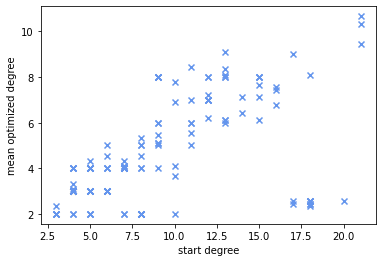

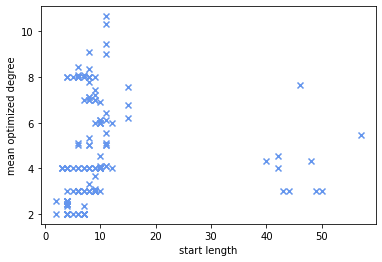

In [498]:
for m in df.groupby('filename').mean().itertuples():
    pl.scatter(m.start_degree, m.best_degree, marker='x', c='cornflowerblue')
pl.xlabel('start degree'); pl.ylabel('mean optimized degree')
pl.figure()
for m in df.groupby('filename').mean().itertuples():
    pl.scatter(m.start_length, m.best_degree, marker='x', c='cornflowerblue')
pl.xlabel('start length'); pl.ylabel('mean optimized degree');

In [493]:
len(benchmark.keys()), len(df['benchmark'].unique())

(15, 15)

In [494]:
from arsenal.viz import name2color
n2c = name2color()

methods = []
names = []
for method, dd in df.groupby(['search', 'graph', 'beam_size']):
    names.append(method)
    methods.append(dd)

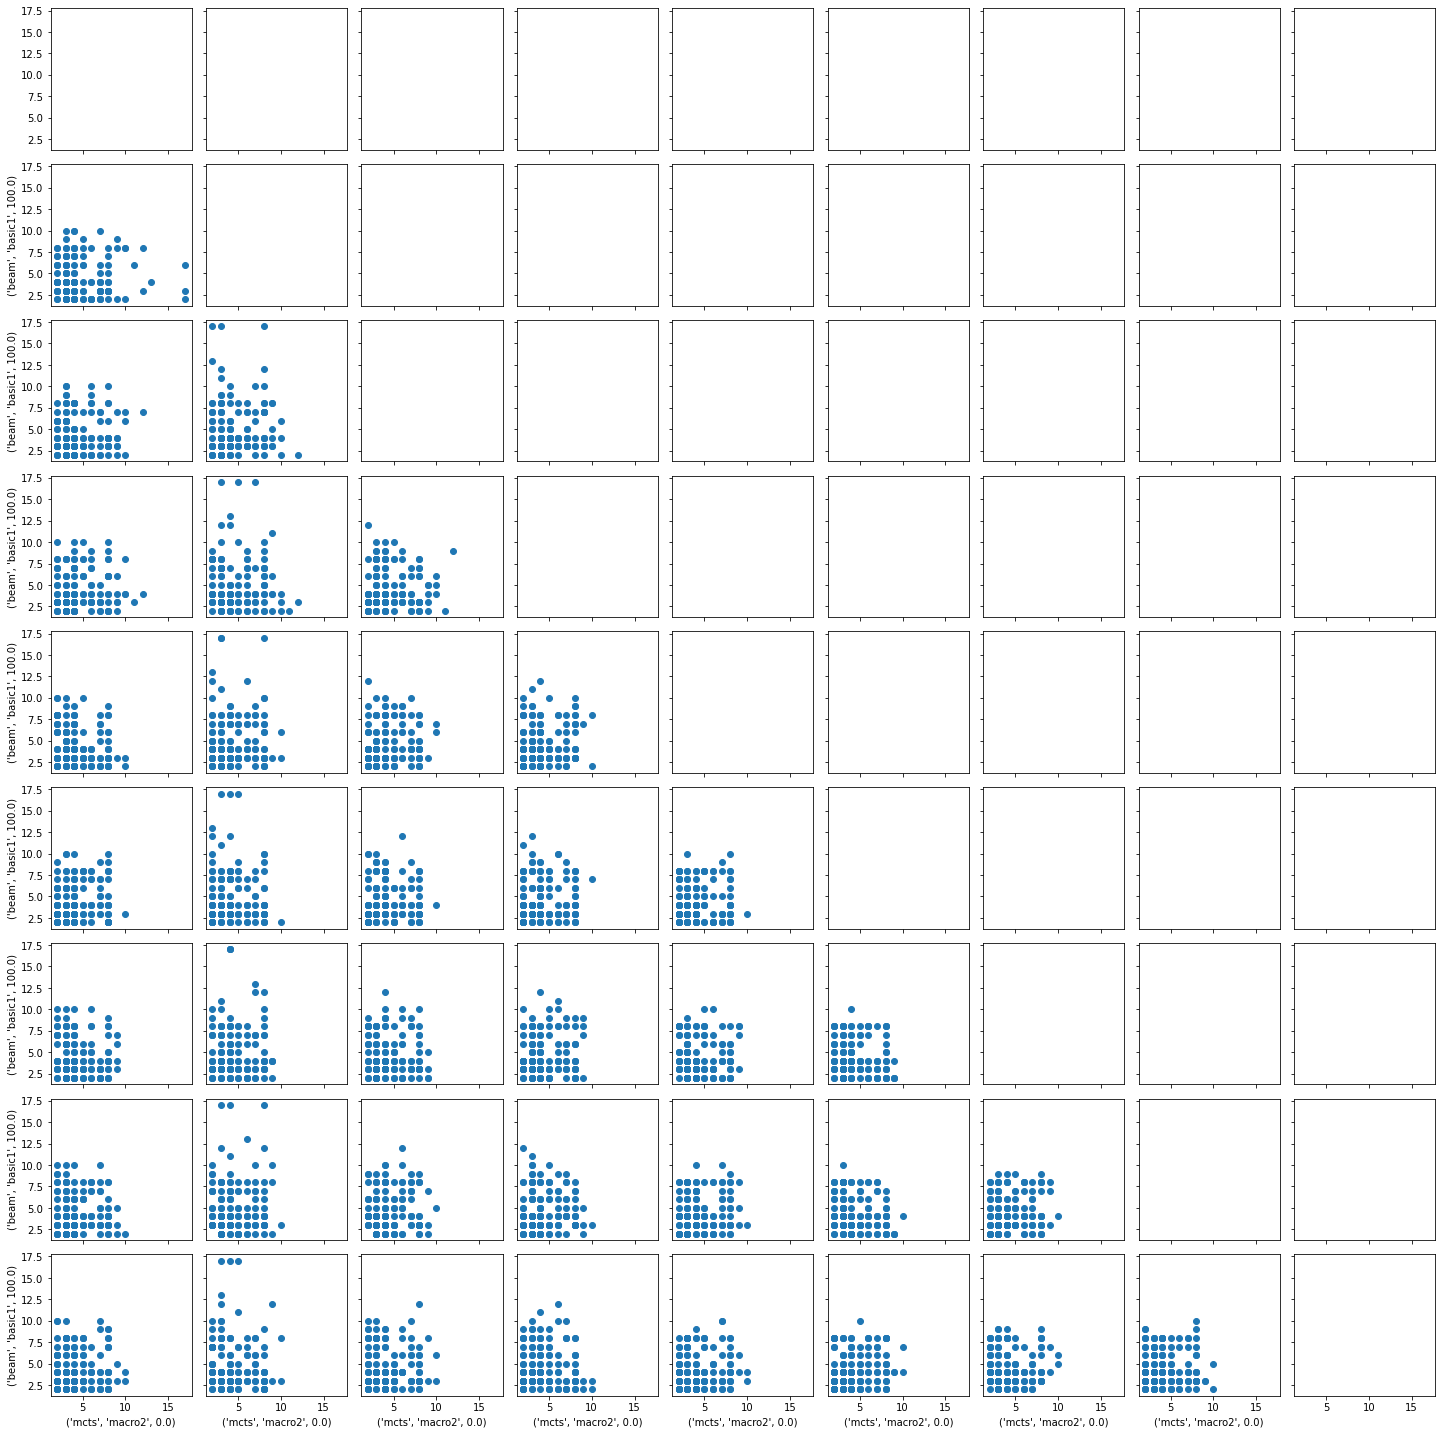

In [495]:
K = len(methods)
fig, ax = pl.subplots(figsize=(20,20), nrows=K, ncols=K, sharex=True, sharey=True)

for i in range(K):
    for j in range(i):
        xx = methods[i]
        yy = methods[j]
         
        def rel_degree(x):
            return (x.best_degree - x.optimal_degree) / (x.start_degree - x.optimal_degree)
        x = rel_degree(xx)
        y = rel_degree(yy)
    
        ax[i,j].scatter(xx.best_degree, y=yy.best_degree)

#        ax[i,j].scatter(x, y)
        if i == K-1: ax[i,j].set_xlabel(names[i])
        if j == 0: ax[i,j].set_ylabel(names[j])

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

In [448]:
b=a[1]


[]

Show instances sorted by optimality rate across all methods.  At the top of the list would be benchmark instances that were rarely or never solved.

In [496]:
df.groupby('filename').mean().sort_values(['optimal'])[['optimal', 'start_degree']].head(15)  # just the head

,optimal,start_degree
filename,,
stress-tests/3/cky0/05.pkl,0.00,15.0
stress-tests/3/split-head/05.pkl,0.00,10.0
stress-tests/3/itg/00.pkl,0.00,21.0
stress-tests/3/cky3/07.pkl,0.00,14.0
stress-tests/3/cky0/01.pkl,0.00,9.0
stress-tests/3/cky0/00.pkl,0.11,6.0
stress-tests/3/cky4/09.pkl,0.11,10.0
stress-tests/3/edit/05.pkl,0.22,16.0
stress-tests/3/bilexical-unlabeled/02.pkl,0.22,11.0


In [ ]:
#filename = 'stress-tests/5/chain-15/00.pkl'
#filename = 'stress-tests/5/bilexical-unlabeled/07.pkl'
#filename = 'stress-tests/3/bilexical-unlabeled/07.pkl'
#filename = 'stress-tests/3/cky0/07.pkl'
filename = 'stress-tests/3/cky0/05.pkl'

In [368]:
p = load(filename)
p.show_transforms()
p.show_analyzers()


## Transforms
original
Unfold(0, 0)
Unfold(38, 0)
Fold(39, frozenset({1, 2}))
Analysis {
  % degree=15
  0: phrase(X, I, K) += phrase(Y, I, K) * rewrite(X, Y). 	% degree=4, can_elim={}
  1: phrase(X, I, K) += word(X, I, K). 	% degree=3, can_elim={}
  2: goal += phrase("ROOT", 0, N) * length(N). 	% degree=1, can_elim={}
  3: rewrite("ROOT", "S", "<.>") += 1.0. 	% degree=0, can_elim={}
  4: rewrite("S", "NP", "VP") += 1.0. 	% degree=0, can_elim={}
  5: rewrite("NP", "Det", "N") += 1.0. 	% degree=0, can_elim={}
  6: rewrite("NP", "NP", "PP") += 1.0. 	% degree=0, can_elim={}
  7: rewrite("VP", "V", "NP") += 1.0. 	% degree=0, can_elim={}
  8: rewrite("VP", "V") += 1.0. 	% degree=0, can_elim={}
  9: rewrite("VP", "VP", "PP") += 1.0. 	% degree=0, can_elim={}
  10: rewrite("PP", "P", "NP") += 1.0. 	% degree=0, can_elim={}
  11: rewrite("<.>", ".") += 1.0. 	% degree=0, can_elim={}
  12: rewrite("NP", "Papa") += 1.0. 	% degree=0, can_elim={}
  13: rewrite("N", "caviar") += 1.0. 	% degree=0, can

In [367]:
xxx = []
for x in iterview(df[df.filename == filename].itertuples(), length=sum(df.filename == filename)):
    directory = Path(x.directory)
    config = load(directory / 'args.pkl')
    #pprint(config.__dict__)
    if (directory / 'log.pkl.bz2').exists():
        log = pd.DataFrame(load(directory / 'log.pkl.bz2'))
    else:
        log = pd.DataFrame(load(directory / 'log.pkl'))
    p = load(directory / 'solution.pkl')
    xxx.append([x, log, config, p])

 11.1% (1/9) [======>                                                 ] 00:00:00


UnpicklingError: pickle data was truncated

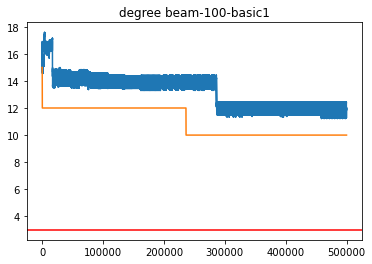

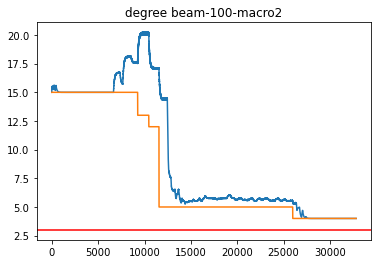

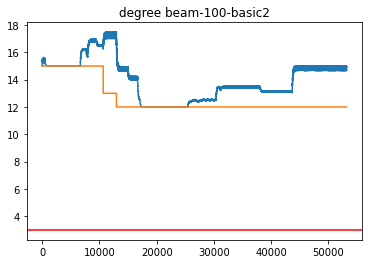

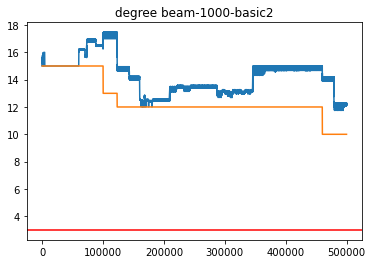

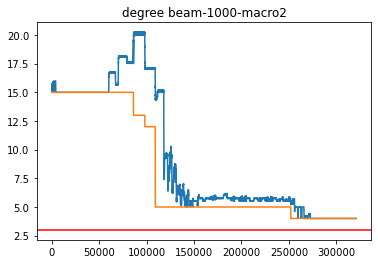

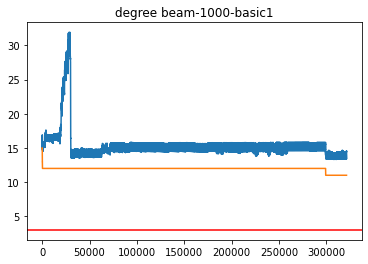

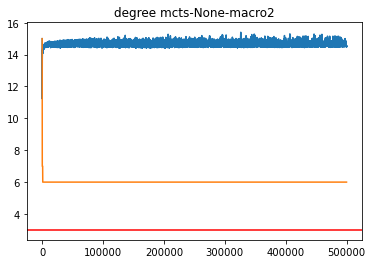

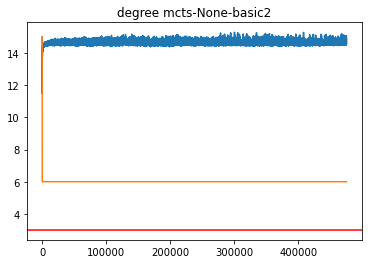

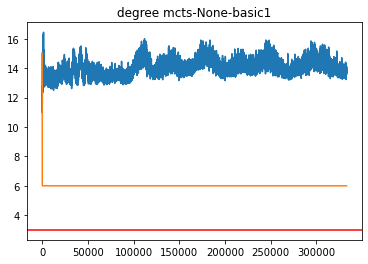

In [265]:
smoothing = 100

for x, log, config, p in sorted(xxx, key = lambda x: x[2].search):
    pl.figure()
    pl.title(f'degree {config.search}-{config.beam_size}-{config.graph}')
    pl.plot(log.degree.ewm(smoothing).mean())
#    pl.plot(log.degree.rolling(smoothing).median())
    pl.plot(np.minimum.accumulate(log.degree))
    pl.axhline(benchmark[config.benchmark].optimal, c='r')
    pl.show()
    
    #pl.figure()
    #pl.title('program length')
    #pl.plot(log['p_length'].ewm(smoothing).mean())

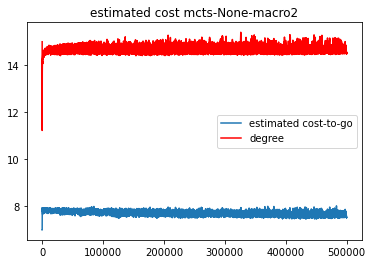

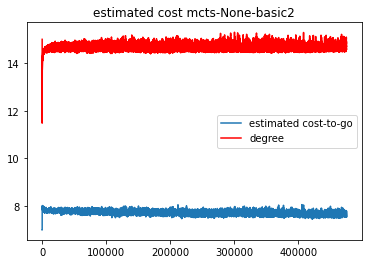

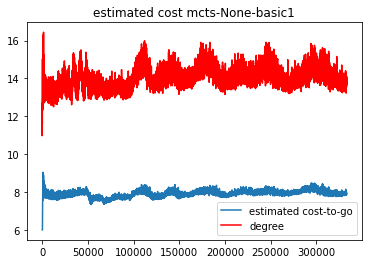

In [266]:
smoothing = 100
for x, log, config, p in sorted(xxx, key = lambda x: x[2].search):
    if config.search != 'mcts': continue
    pl.figure()
    pl.title(f'estimated cost {config.search}-{config.beam_size}-{config.graph}')
    pl.plot((log['c'] / log['n']).ewm(smoothing).mean(), label='estimated cost-to-go')
    pl.plot(log.degree.ewm(smoothing).mean(), c='r', label='degree')
    pl.legend(loc='best')
    pl.show()

What were the transforms that were performed on this instance

In [267]:
print(filename)
p = load(filename)
p.show_transforms()
p.show_analyzers()

stress-tests/3/cky0/05.pkl

## Transforms
original
Unfold(0, 0)
Unfold(38, 0)
Fold(39, frozenset({1, 2}))
Analysis {
  % degree=15
  0: phrase(X, I, K) += phrase(Y, I, K) * rewrite(X, Y). 	% degree=4, can_elim={}
  1: phrase(X, I, K) += word(X, I, K). 	% degree=3, can_elim={}
  2: goal += phrase("ROOT", 0, N) * length(N). 	% degree=1, can_elim={}
  3: rewrite("ROOT", "S", "<.>") += 1.0. 	% degree=0, can_elim={}
  4: rewrite("S", "NP", "VP") += 1.0. 	% degree=0, can_elim={}
  5: rewrite("NP", "Det", "N") += 1.0. 	% degree=0, can_elim={}
  6: rewrite("NP", "NP", "PP") += 1.0. 	% degree=0, can_elim={}
  7: rewrite("VP", "V", "NP") += 1.0. 	% degree=0, can_elim={}
  8: rewrite("VP", "V") += 1.0. 	% degree=0, can_elim={}
  9: rewrite("VP", "VP", "PP") += 1.0. 	% degree=0, can_elim={}
  10: rewrite("PP", "P", "NP") += 1.0. 	% degree=0, can_elim={}
  11: rewrite("<.>", ".") += 1.0. 	% degree=0, can_elim={}
  12: rewrite("NP", "Papa") += 1.0. 	% degree=0, can_elim={}
  13: rewrite("N", "caviar

In [268]:
for x, log, config, p in sorted(xxx, key = lambda x: x[2].search):
    t = p.eliminate_constant_rules().greedy_binarize()
    print()
    print(config.search, config.beam_size, config.graph)
    if t.degree < p.degree:
        t.show_analyzers()
    else:
        print(p.degree, '->', t.degree)


beam 100 basic1
Analysis {
  % degree=5
  0: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  1: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  2: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  3: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  4: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  5: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("man", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("woman", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("moon", I, K). 	% degree=2, can_elim={}
  


beam 100 macro2
Analysis {
  % degree=3
  0: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  1: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  2: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  3: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  4: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  5: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("man", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("woman", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("moon", I, K). 	% degree=2, can_elim={}
  


beam 100 basic2
Analysis {
  % degree=5
  0: phrase(X, I, K) += word(X, I, K). 	% degree=3, can_elim={}
  1: goal += phrase("ROOT", 0, N) * length(N). 	% degree=1, can_elim={}
  2: phrase(X, I, K) += $gen(J, K, X, Y) * word(Y, I, J). 	% degree=5, can_elim={}
  3: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  4: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  5: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  


beam 1000 basic2
Analysis {
  % degree=5
  0: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  1: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  2: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  3: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  4: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  5: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("man", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("woman", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("moon", I, K). 	% degree=2, can_elim={}
 


beam 1000 macro2
Analysis {
  % degree=3
  0: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  1: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  2: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  3: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  4: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  5: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("man", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("woman", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("moon", I, K). 	% degree=2, can_elim={}
 


beam 1000 basic1
Analysis {
  % degree=5
  0: phrase("VP", I, K) += phrase("V", I, K). 	% degree=2, can_elim={}
  1: phrase("<.>", I, K) += phrase(".", I, K). 	% degree=2, can_elim={}
  2: phrase("NP", I, K) += phrase("Papa", I, K). 	% degree=2, can_elim={}
  3: phrase("N", I, K) += phrase("caviar", I, K). 	% degree=2, can_elim={}
  4: phrase("N", I, K) += phrase("spoon", I, K). 	% degree=2, can_elim={}
  5: phrase("N", I, K) += phrase("fork", I, K). 	% degree=2, can_elim={}
  6: phrase("N", I, K) += phrase("telescope", I, K). 	% degree=2, can_elim={}
  7: phrase("N", I, K) += phrase("boy", I, K). 	% degree=2, can_elim={}
  8: phrase("N", I, K) += phrase("girl", I, K). 	% degree=2, can_elim={}
  9: phrase("N", I, K) += phrase("baby", I, K). 	% degree=2, can_elim={}
  10: phrase("N", I, K) += phrase("man", I, K). 	% degree=2, can_elim={}
  11: phrase("N", I, K) += phrase("woman", I, K). 	% degree=2, can_elim={}
  12: phrase("N", I, K) += phrase("moon", I, K). 	% degree=2, can_elim={}
 


mcts None macro2
6 -> 6

mcts None basic2
6 -> 6

mcts None basic1
6 -> 6
